# XGBoost

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import pickle
import time
import xgboost as xgb
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})

# Metrics
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_score, accuracy_score, recall_score, f1_score, precision_recall_curve

# Load Data

In [2]:
# Load pickled data
df = pd.read_pickle("data/yelp_df_final.pkl")

# Split data
train_df = df[df["dataset"] == "train"]
valid_df = df[df["dataset"] == "val"].reset_index(drop = True)
test_df  = df[df["dataset"] == "test"].reset_index(drop = True)

In [3]:
dev_mode = False
n = 100

if dev_mode:
    train_df = train_df.loc[:n]
    valid_df = valid_df.loc[:n]
    test_df = test_df.loc[:n]

In [4]:
# Parameters excluded from predictions
exclude = ["review_id", 
           "business_id", 
           "user_id", 
           "label", 
           "date", 
           "categories", 
           "is_open",
           "postal_code", 
           "dataset"]

# Predictors
predictors = list(train_df.columns)
for col in exclude:   
    predictors.remove(col)

# Label
outcome = "label"

In [5]:
# Train features and labels
X_train = np.array(train_df[predictors])
y_train = np.array(train_df[outcome])

# Validation features and labels
X_valid = np.array(valid_df[predictors])
y_valid = np.array(valid_df[outcome])

# Test features and labels
X_test  = np.array(test_df[predictors])
y_test  = np.array(test_df[outcome])

In [6]:
# Save XGBoost data types 
dtrain = xgb.DMatrix(X_train, label = y_train)
dvalid = xgb.DMatrix(X_valid, label = y_valid)
dtest  = xgb.DMatrix(X_test,  label = y_test)

# Set Parameters

In [7]:
# Hyperparameters for model
param = {'max_depth': 4,
         'eta': 1.0,
         'min_child_weight': 1}

# Learning task and corresponding learning objective
# Logistic regression for binary classification, output probability
param['objective'] = 'binary:logistic'

# Evaluation metrics for validation data 
# (wrong cases) / (all cases)
param['eval_metric'] = 'error' 

# Specify validation set to watch performance
evallist = [(dvalid, 'eval'), (dtrain, 'train')]

# Number of rounds for boosting
num_round = 200

# Validation error needs to decrease at least every early_stopping_rounds 
early_stopping_rounds = 2

# Training

In [8]:
# Start timer 
start_time = time.time()

# Train model
bst = xgb.train(params = param, 
                dtrain = dtrain, 
                num_boost_round = num_round, 
                evals = evallist,
                early_stopping_rounds = early_stopping_rounds)

# End timer
end_time = time.time()
print("Time for training: {:.2f} seconds".format(end_time - start_time))
print("Best iteration         {}".format(bst.best_iteration))

try:
    print("Best validation error: {}".format(bst.best_score))
    print("Best ntree limit:      {}".format(bst.best_ntree_limit))
except:
    print("Early stopping did not occur")

[22:48:17] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	eval-error:0.256985	train-error:0.262801
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 2 rounds.
[1]	eval-error:0.253573	train-error:0.260447
[2]	eval-error:0.247855	train-error:0.25525
[3]	eval-error:0.24583	train-error:0.254627
[4]	eval-error:0.244654	train-error:0.253653
[5]	eval-error:0.243736	train-error:0.252367
[6]	eval-error:0.243527	train-error:0.252024
[7]	eval-error:0.243482	train-error:0.251868
[8]	eval-error:0.242165	train-error:0.250652
[9]	eval-error:0.241107	train-error:0.249853
[10]	eval-error:0.240696	train-error:0.24948
[11]	eval-error:0.240493	train-error:0.249277
[12]	eval-error:0.240405	train-error:0.249065
[13]	eval-error:0.240288	train-error:0.248897
[14]	eval-error:0.24

In [9]:
# Save model
bst.save_model("results/xgb_4.model")

## Validation Set Performance

In [10]:
# Predict using best validation set performer
prob_valid = bst.predict(dvalid, ntree_limit = bst.best_ntree_limit)
pred_valid = [0 if x < 0.5 else 1 for x in prob_valid]

In [11]:
# Prediction metrics
print("Accuracy:  {:.3f}%".format(accuracy_score(y_valid, pred_valid)))
print("Precision: {:.3f}%".format(precision_score(y_valid, pred_valid)))
print("Recall:    {:.3f}%".format(recall_score(y_valid, pred_valid)))
print("F1:        {:.3f}%".format(f1_score(y_valid, pred_valid)))

Accuracy:  0.762%
Precision: 0.790%
Recall:    0.732%
F1:        0.760%


Text(0.5,1,'Validation Set Receiver Operator Characteristic')

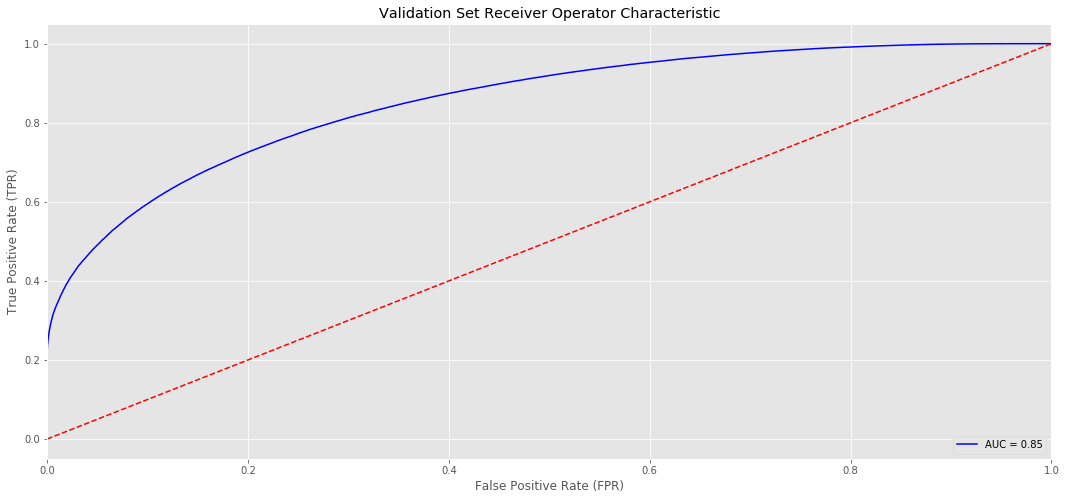

In [12]:
# Validation set AUROC curve
fpr, tpr, threshold = roc_curve(y_valid, prob_valid)
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize=(18, 8))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0,1], [0, 1], 'r--')
plt.legend(loc = 'lower right')
plt.xlim(0,1)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Validation Set Receiver Operator Characteristic")

# Test Set Performance

In [13]:
# Predict using best validation set performer
prob_test = bst.predict(dtest, ntree_limit = bst.best_ntree_limit)
pred_test = [0 if x < 0.5 else 1 for x in prob_test]

In [14]:
# Prediction metrics
print("Accuracy:  {:.3f}%".format(accuracy_score(y_test, pred_test)))
print("Precision: {:.3f}%".format(precision_score(y_test, pred_test)))
print("Recall:    {:.3f}%".format(recall_score(y_test, pred_test)))
print("F1:        {:.3f}%".format(f1_score(y_test, pred_test)))

Accuracy:  0.767%
Precision: 0.794%
Recall:    0.742%
F1:        0.767%


Text(0.5,1,'Test Set Receiver Operator Characteristic')

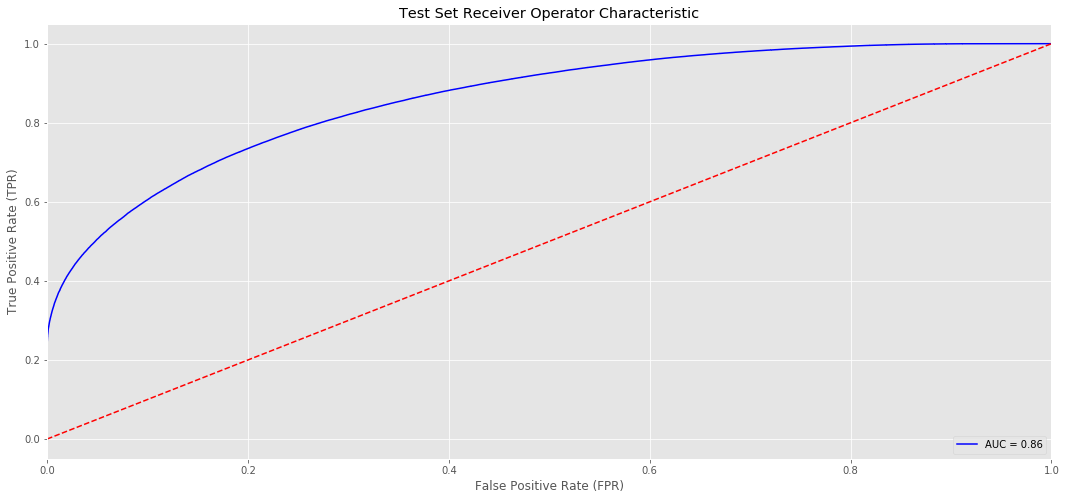

In [15]:
# Validation set AUROC curve
fpr, tpr, threshold = roc_curve(y_test, prob_test)
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize=(18, 8))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0,1], [0, 1], 'r--')
plt.legend(loc = 'lower right')
plt.xlim(0,1)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Test Set Receiver Operator Characteristic")